# Day 3: reduced model 基础作业

In [12]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt

## 1. Building a Leaky Integrate-and-Fire (LIF) neuron model
The mathematic expression of the LIF neuron model is as follows:
\begin{align}
    \tau \ \frac{\mathrm{d}V}{\mathrm{d}t} &= -(V - V_{rest}) + RI  \\
    \mathrm{if}\ V &> V_{th}, \ V \gets V_{reset}  \ \ \mathrm{last} \ \ t_\mathrm{ref}
\end{align}

In [ ]:
class LIF(bp.dyn.NeuDyn):
  def __init__(self, size, V_rest=0., V_reset=-5., V_th=20., R=1., tau=10., t_ref=5., **kwargs):
    # 初始化父类
    super(LIF, self).__init__(size=size, **kwargs)

    # 初始化参数
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref  # 不应期时长

    # 初始化变量
    # todo: 初始化膜电压self.V：统一设置为V_reset，或增加一些随机性，使之在V_reset附近波动
    # self.V = 
    # todo: 初始化不应期记录self.refractory，bool类型，如果神经元处于不应期则为1，否则为0
    # self.refractory =
    # todo: 初始化上一次脉冲发放时间记录self.t_last_spike，记录神经元上一次发放脉冲的时间，统一初始化为0即可
    # self.t_last_spike =
    # todo: 初始化脉冲发放状态self.spike：bool类型，如果神经元正处于发放状态则为1，否则为0
    # self.spike = 
    
    self.input = bm.Variable(bm.zeros(self.num))  # 初始化外部输入电流

    # 使用指数欧拉方法进行积分
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  # 定义膜电位关于时间变化的微分方程
  def derivative(self, V, t, Iext):  # Iext为外部输入电流
    # todo: dVdt = 
    dVdt = ...
    return dVdt

  def update(self):
    _t, _dt = bp.share['t'], bp.share['dt']  # 获取时间_t和积分步长_dt
    
    # 以数组的方式对神经元进行更新
    
    # todo: 数值积分，更新膜电位，用到self.integral()，暂时存储在变量V中 （先不考虑是否处于不应期）
    # V = 
    
    refractory = (_t - self.t_last_spike) <= self.t_ref  # 判断神经元是否处于不应期
    V = self.integral(self.V, _t, self.input, dt=_dt)  # 根据时间步长更新膜电位
    V = bm.where(refractory, self.V, V)  # 若处于不应期，则返回原始膜电位self.V，否则返回更新后的膜电位V

    spike = V > self.V_th  # 将大于阈值的神经元标记为发放了脉冲
    self.spike[:] = spike  # 更新神经元脉冲发放状态
    self.t_last_spike[:] = bm.where(spike, _t, self.t_last_spike)  # 更新最后一次脉冲发放时间
    
    self.V[:] = bm.where(spike, self.V_reset, V)  # 将发放了脉冲的神经元膜电位置为V_reset，其余不变
    self.refractory[:] = bm.logical_or(refractory, spike)  # 更新神经元是否处于不应期
  
    self.input[:] = 0.  # 重置外界输入

### Run the LIF model to see if you are correct

In [13]:
def run_LIF():
  # 运行LIF模型

  group = LIF(1)
  runner = bp.DSRunner(group, monitors=['V'], inputs=('input', 22.))
  runner(200)  # 运行时长为200ms

  # 结果可视化
  fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
  ax = fig.add_subplot(gs[0, 0])
  plt.plot(runner.mon.ts, runner.mon.V)
  plt.xlabel(r'$t$ (ms)')
  plt.ylabel(r'$V$ (mV)')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.show()

In [ ]:
run_LIF()

## Answer 1

In [14]:
class LIF(bp.dyn.NeuDyn):
  def __init__(self, size, V_rest=0., V_reset=-5., V_th=20., R=1., tau=10., t_ref=5., **kwargs):
    # 初始化父类
    super(LIF, self).__init__(size=size, **kwargs)

    # 初始化参数
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref  # 不应期时长

    # 初始化变量
    self.V = bm.Variable(bm.random.randn(self.num) + V_reset)
    self.input = bm.Variable(bm.zeros(self.num))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)  # 上一次脉冲发放时间
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))  # 是否处于不应期
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))  # 脉冲发放状态

    # 使用指数欧拉方法进行积分
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  # 定义膜电位关于时间变化的微分方程
  def derivative(self, V, t, Iext):
    dVdt = (-V + self.V_rest + self.R * Iext) / self.tau
    return dVdt

  def update(self):
    _t, _dt = bp.share['t'], bp.share['dt']
    # 以数组的方式对神经元进行更新
    refractory = (_t - self.t_last_spike) <= self.t_ref  # 判断神经元是否处于不应期
    V = self.integral(self.V, _t, self.input, dt=_dt)  # 根据时间步长更新膜电位
    V = bm.where(refractory, self.V, V)  # 若处于不应期，则返回原始膜电位self.V，否则返回更新后的膜电位V
    spike = V > self.V_th  # 将大于阈值的神经元标记为发放了脉冲
    self.spike[:] = spike  # 更新神经元脉冲发放状态
    self.t_last_spike[:] = bm.where(spike, _t, self.t_last_spike)  # 更新最后一次脉冲发放时间
    self.V[:] = bm.where(spike, self.V_reset, V)  # 将发放了脉冲的神经元膜电位置为V_reset，其余不变
    self.refractory[:] = bm.logical_or(refractory, spike)  # 更新神经元是否处于不应期
    self.input[:] = 0.  # 重置外界输入

  0%|          | 0/2000 [00:00<?, ?it/s]

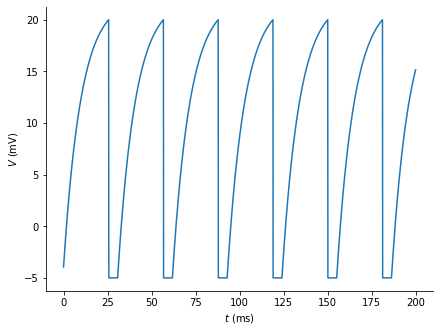

In [15]:
run_LIF()

## 2. Building a AdEx neuron model

The mathematic expression of the Izhikevich neuron model is as follows:
\begin{align}
    \tau_m \frac{\mathrm{d}V}{\mathrm{d}t} &= -(V - V_{rest}) + \Delta_T \ e^{\frac{V-V_T}{\Delta_T}}  - Rw + RI\\
    \tau_w \frac{\mathrm{d}w}{\mathrm{d}t} &= a \left(V - V_{rest}\right) - w + b \ \tau_w \sum_{t^{(f)}} \delta (t - t^{(f)}) \\
    \mathrm{if}\ V &> V_{th}, \ V \gets V_{reset}  \ \ \mathrm{last} \ \ t_\mathrm{ref}
\end{align}

Please fill the <i>todo</i> blanks of the following code.

In [8]:
class AdEx(bp.dyn.NeuDyn):
  def __init__(self, size, 
               V_rest=-65., V_reset=-68., V_th=-30., V_T=-59.9, delta_T=3.48,
               a=1., b=1., R=1., tau=10., tau_w=30., tau_ref=0.,
               **kwargs):
    # 初始化父类
    super(AdEx, self).__init__(size=size, **kwargs)

    # 初始化参数
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.V_T = V_T
    self.delta_T = delta_T
    self.a = a
    self.b = b
    self.R = R
    self.tau = tau
    self.tau_w = tau_w
    
    self.tau_ref = tau_ref

    # 初始化变量
    self.V = bm.Variable(bm.random.randn(self.num) - 65.)
    self.w = bm.Variable(bm.zeros(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)  # 上一次脉冲发放时间
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))  # 是否处于不应期
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))  # 脉冲发放状态

    # 定义积分器
    self.integral = bp.odeint(f=self.derivative, method='exp_auto')

  def dV(self, V, t, w, I):
    # TODO: 定义膜电位关于时间变化的微分方程
    dVdt = ...
    return dVdt

  def dw(self, w, t, V):
    # TODO: 定义w关于时间变化的微分方程
    dwdt = ...
    return dwdt

  @property
  def derivative(self):
    # todo: 将两个微分方程联合为一个，以便同时积分（使用brainpy.JointEq() )
    return ...

  def update(self):
    t, dt = bp.share['t'], bp.share['dt']
    # TODO: # 更新变量V, u，暂存在V, u中
    # V, u = 
    
    refractory = (t - self.t_last_spike) <= self.tau_ref  # 判断神经元是否处于不应期
    V = bm.where(refractory, self.V, V)  # 若处于不应期，则返回原始膜电位self.V，否则返回更新后的膜电位V
    spike = V > self.V_th  # 将大于阈值的神经元标记为发放了脉冲
    self.spike[:] = spike  # 更新神经元脉冲发放状态
    self.t_last_spike[:] = bm.where(spike, t, self.t_last_spike)  # 更新最后一次脉冲发放时间

    # todo: 将发放了脉冲的神经元的V置为V_reset，其余不变，并传回给self.V（注意更新时要使用in-place udpdate)
    # 
    # todo: 将发放了脉冲的神经元的w增加b，其余不变，并传回给self.w（注意更新时要使用in-place udpdate)
    # 

    self.refractory[:] = bm.logical_or(refractory, spike)  # 更新神经元是否处于不应期
    self.input[:] = 0.  # 重置外界输入

### Run the AdEx model to see if you are correct

In [16]:
def run_AdEx():
  # 运行AdEx模型
  group = AdEx(10)
  runner = bp.DSRunner(group, monitors=['V', 'w'], inputs=('input', 10.))
  runner(300)
  bp.visualize.line_plot(runner.mon.ts, runner.mon.V, legend='V', show=False)
  bp.visualize.line_plot(runner.mon.ts, runner.mon.w, legend='w', show=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

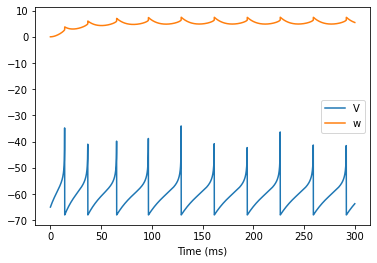

In [10]:
run_AdEx()

## Answer 2

In [30]:
class AdEx(bp.dyn.NeuDyn):
  def __init__(self, size, 
               V_rest=-65., V_reset=-68., V_th=-30., V_T=-59.9, delta_T=2.,
               a=1., b=10., R=1., tau=10., tau_w=100., tau_ref=0.,
               **kwargs):
    # 初始化父类
    super(AdEx, self).__init__(size=size, **kwargs)

    # 初始化参数
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.V_T = V_T
    self.delta_T = delta_T
    self.a = a
    self.b = b
    self.R = R
    self.tau = tau
    self.tau_w = tau_w
    
    self.tau_ref = tau_ref

    # 初始化变量
    self.V = bm.Variable(bm.random.randn(self.num) - 65.)
    self.w = bm.Variable(bm.ones(self.num) * -15.)
    self.input = bm.Variable(bm.zeros(self.num))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)  # 上一次脉冲发放时间
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))  # 是否处于不应期
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))  # 脉冲发放状态

    # 定义积分器
    self.integral = bp.odeint(f=self.derivative, method='exp_auto')

  def dV(self, V, t, w, I):
    exp = self.delta_T * bm.exp((V - self.V_T) / self.delta_T)
    dVdt = (- V + self.V_rest + exp - self.R * w + self.R * I) / self.tau
    return dVdt

  def dw(self, w, t, V):
    dwdt = (self.a * (V - self.V_rest) - w) / self.tau_w
    return dwdt

  @property
  def derivative(self):
    return bp.JointEq([self.dV, self.dw])

  def update(self):
    t, dt = bp.share['t'], bp.share['dt']
    V, w = self.integral(self.V.value, self.w.value, t, self.input, dt)
    refractory = (t - self.t_last_spike) <= self.tau_ref  # 判断神经元是否处于不应期
    V = bm.where(refractory, self.V, V)  # 若处于不应期，则返回原始膜电位self.V，否则返回更新后的膜电位V
    spike = V > self.V_th  # 将大于阈值的神经元标记为发放了脉冲
    self.spike[:] = spike  # 更新神经元脉冲发放状态
    self.t_last_spike[:] = bm.where(spike, t, self.t_last_spike)  # 更新最后一次脉冲发放时间
    self.V[:] = bm.where(spike, self.V_reset, V)  # 将发放了脉冲的神经元膜电位置为V_reset，其余不变
    self.w[:] = bm.where(spike, w + self.b, w)    # 更新自适应电流
    self.refractory[:] = bm.logical_or(refractory, spike)  # 更新神经元是否处于不应期
    self.input[:] = 0.  # 重置外界输入

  0%|          | 0/3000 [00:00<?, ?it/s]

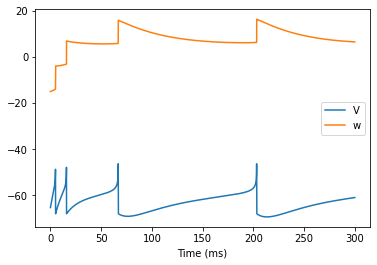

In [31]:
run_AdEx()

### Extended: 
You can also modify the parameters (e.g, a, b, and the input current) in the AdEx model to see how they affect the firing pattern.

## Phase plane analysis of the AdEx neuron model

In [19]:
AdEx = bp.neurons.AdExIF  # 从brainpy导入现成的模型

neuron_AdEx = AdEx(
    size=1,
    a=1.,
    b=10.,
    tau=10.,
    tau_w=100.,
    V_reset=-60.,
    R=.5, delta_T=2., V_rest=-70., V_th=-30., V_T=-50.
)

Iext = 55.

# 可以尝试的参数组合包括但不限于：
# a        0.01, 0.01, 0.5,  -0.5, 1.,   -1.
# b        60.,  5.,   7.,   7.,   10.,  5.
# tau      20.,  20.,  5.,   5.,   10.,  5.
# tau_w    30.,  100., 100., 100., 100., 100.
# V_reset  -55., -55., -51., -47., -60., -60.
# Iext     65.,  65.,  65.,  65.,  55.,  25.

def AdEx_patterns(group):
    group.V[:], group.w[:] = group.V_reset, 0
    runner = bp.DSRunner(group, monitors=['V', 'w', 'spike'], inputs=('input', Iext))
    runner.run(500.)

    runner.mon.V = np.where(runner.mon.spike, 20., runner.mon.V)

    plt.plot(runner.mon.ts, runner.mon.V, label='V')
    plt.plot(runner.mon.ts, runner.mon.w, label='w')
    plt.legend()
    plt.xlabel(r'$t$ (ms)')

    plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

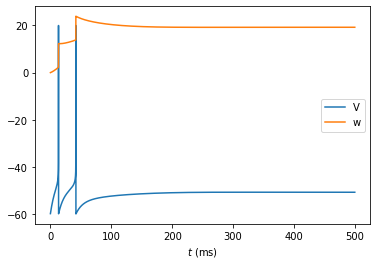

In [20]:
AdEx_patterns(neuron_AdEx)

### Phase plane analysis: Please fill the <i>todo</i> blanks of the following code.

In [21]:
def ppa_AdEx(group):
    bm.enable_x64()
    
    v_range = [-70., -40.]
    w_range = [-10., 50.]
    
    phase_plane_analyzer = bp.analysis.PhasePlane2D(
        model=group,
        # todo: 待分析变量及其分析区间
        # target_vars=
        # todo: 需要更新的变量
        # pars_update=
        resolutions=0.05
    )

    # 画出V, w的零增长曲线
    phase_plane_analyzer.plot_nullcline()
    # 画出奇点
    phase_plane_analyzer.plot_fixed_point()
    # 画出向量场
    phase_plane_analyzer.plot_vector_field()
    
    # 分段画出V, w的变化轨迹
    group.V[:], group.w[:] = group.V_reset, 0
    runner = bp.DSRunner(group, monitors=['V', 'w', 'spike'], inputs=('input', Iext))
    runner(500)
    spike = runner.mon.spike.squeeze()
    s_idx = np.where(spike)[0]  # 找到所有发放动作电位对应的index
    s_idx = np.concatenate(([0], s_idx, [len(spike) - 1]))  # 加上起始点和终止点的index
    for i in range(len(s_idx) - 1):
        vs = runner.mon.V[s_idx[i]: s_idx[i + 1]]
        ws = runner.mon.w[s_idx[i]: s_idx[i + 1]]
        plt.plot(vs, ws, color='darkslateblue')
        
    # 画出虚线 x = V_reset
    plt.plot([group.V_reset, group.V_reset], w_range, '--', color='grey', zorder=-1)
    
    plt.show()

In [ ]:
ppa_AdEx(neuron_AdEx)

## Answer 3

In [23]:
def ppa_AdEx(group):
    bm.enable_x64()
    
    v_range = [-70., -40.]
    w_range = [-10., 50.]
    
    phase_plane_analyzer = bp.analysis.PhasePlane2D(
        model=group,
        target_vars={'V': v_range, 'w': w_range, },  # 待分析变量
        pars_update={'I': Iext},  # 需要更新的变量
        resolutions=0.05
    )

    # 画出V, w的零增长曲线
    phase_plane_analyzer.plot_nullcline()
    # 画出奇点
    phase_plane_analyzer.plot_fixed_point()
    # 画出向量场
    phase_plane_analyzer.plot_vector_field()
    
    # 分段画出V, w的变化轨迹
    group.V[:], group.w[:] = group.V_reset, 0
    runner = bp.DSRunner(group, monitors=['V', 'w', 'spike'], inputs=('input', Iext))
    runner(500)
    spike = runner.mon.spike.squeeze()
    s_idx = np.where(spike)[0]  # 找到所有发放动作电位对应的index
    s_idx = np.concatenate(([0], s_idx, [len(spike) - 1]))  # 加上起始点和终止点的index
    for i in range(len(s_idx) - 1):
        vs = runner.mon.V[s_idx[i]: s_idx[i + 1]]
        ws = runner.mon.w[s_idx[i]: s_idx[i + 1]]
        plt.plot(vs, ws, color='darkslateblue')
        
    # 画出虚线 x = V_reset
    plt.plot([group.V_reset, group.V_reset], w_range, '--', color='grey', zorder=-1)
    
    plt.show()

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 1240 candidates
I am trying to filter out duplicate fixed points ...
	Found 3 fixed points.
	#1 V=-50.7488997195696, w=19.248851709944457 is a stable focus.
	#2 V=-47.94941233679148, w=22.05046184198845 is a saddle node.
	#3 V=-47.95256963921971, w=22.03969187742025 is a saddle node.
I am creating the vector field ...


  0%|          | 0/5000 [00:00<?, ?it/s]

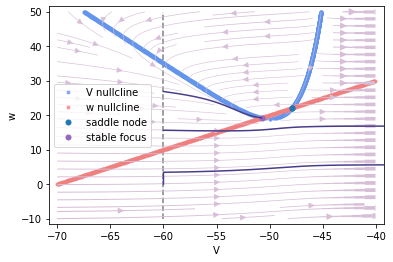

In [24]:
ppa_AdEx(neuron_AdEx)

### Extended: 
You can also modify the parameters (e.g, a, b, tau, tau_w, and the input current) in the AdEx model to see how they affect the firing pattern. Do the phase plane analysis again and try to explain the firing pattern according to the analysis result.